# Macroscopic Smell Test
In this notebook, we look at how different types of fitting parameters change within a small time window in our TFO PPG probe data. The goal is to determine if there is any pattern that can be used to track $\mu_a$. The patterns should also agree with whatever we observe from simulation.  

Essentially, I want to know if the fitting scheme I am using currently is actually good.


In [112]:
from itertools import product
from typing import List, Union
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from TFO_dataset import SheepData
from inverse_modelling_tfo.data.intensity_interpolation import get_interpolate_fit_params, get_interpolate_fit_params_custom
from inverse_modelling_tfo.data.interpolation_function_zoo import *
from inverse_modelling_tfo.data.tfo_data_helpers import transform_tfo_data

In [113]:
# Load Data
tag = {'experiment_number': 5, 'experiment_round': 1, 'experiment_year_prefix': 'sp2022',
       'additional_info': '', 'data_version': 'iq_demod_optical'}
START_TIME_SECONDS = 1600
END_TIME_SECONDS = 1700
WEIGHTS = [0, 1]
data = SheepData('iq_demod_optical').get_data_from_tag(tag)
data = data.iloc[START_TIME_SECONDS * 80 : END_TIME_SECONDS * 80, :]
print(f'Sample Length : {len(data)}')

Sample Length : 8000


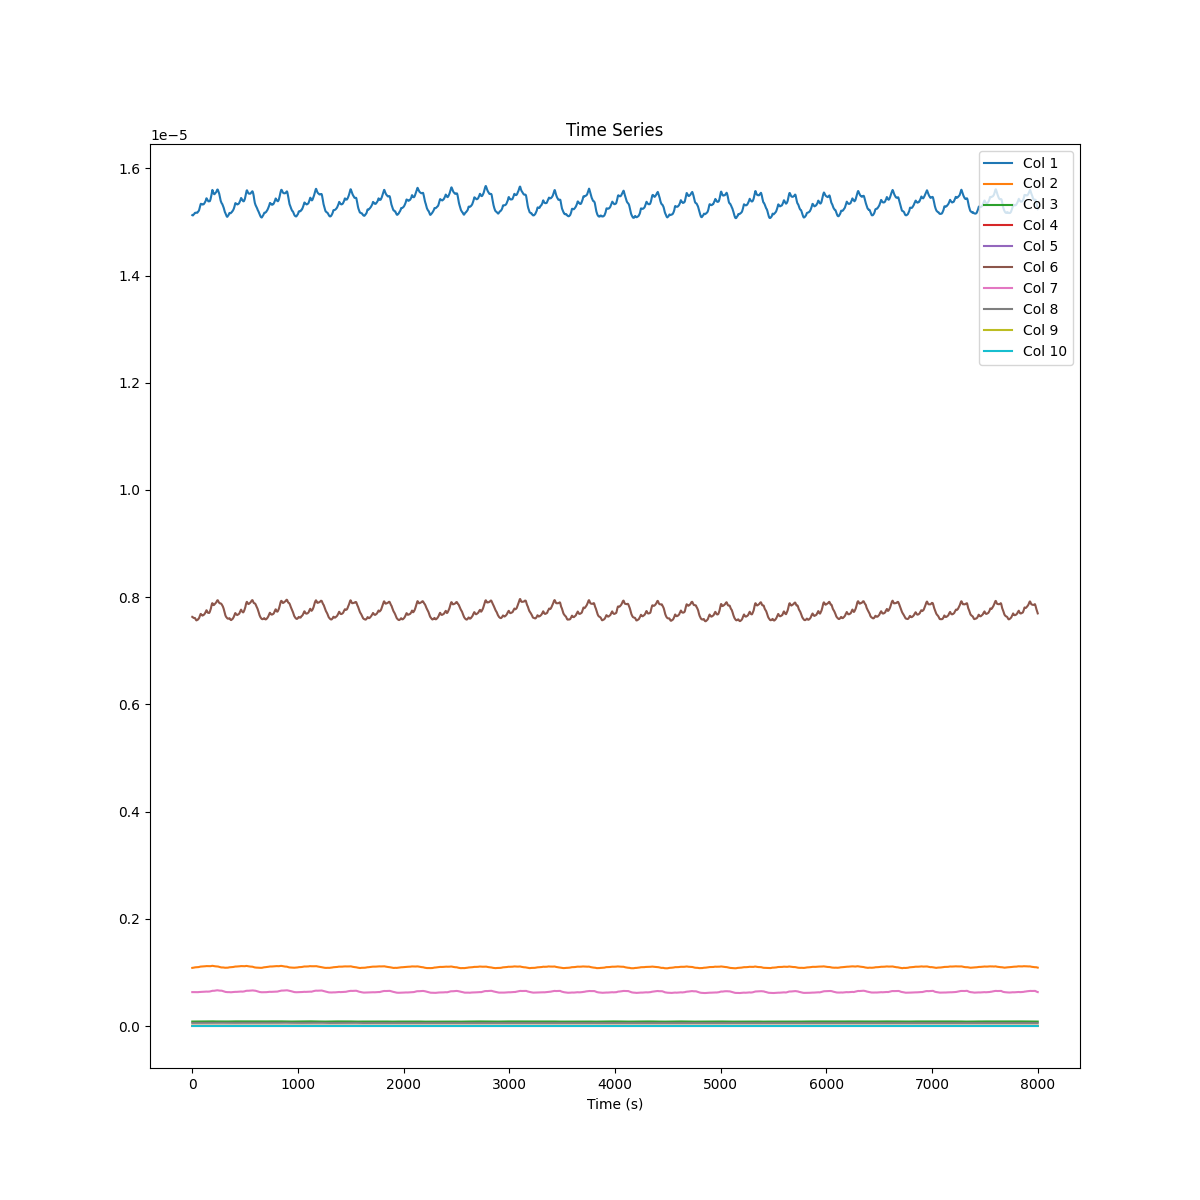

In [114]:
plt.figure(figsize=(12, 12))
plt.title("Time Series")
for col in range(data.to_numpy().shape[1]):
    plt.plot(data.to_numpy()[:, col], label=f'Col {col + 1}')
time_axis = np.arange(0, data.to_numpy().shape[0]/80, 1/80)
plt.xlabel('Time (s)')
plt.legend()
plt.show()

In [115]:
sdd = SheepData('iq_demod_optical').get_sdd_distance(tag)
data = transform_tfo_data(data, sdd)
data.head()

,SDD,Intensity,Wave Int
0,15.0,1.512706e-05,1.0
1,30.0,1.086090e-06,1.0
2,45.0,8.485393e-08,1.0
3,70.0,5.616411e-09,1.0
4,100.0,1.911713e-09,1.0


In [116]:
fit_params = get_interpolate_fit_params_custom(
    data, exponenet_4, sdd_chunk_size=len(sdd), weights=WEIGHTS, return_alpha=True)
fit_params.head()

,Wave Int,alpha0,alpha1,alpha2,alpha3
0,1.0,36.213528,-180.707826,162.243589,-26.467643
1,1.0,36.235729,-180.833728,162.367741,-26.488279
2,1.0,36.252489,-180.933621,162.467659,-26.505250
3,1.0,36.267337,-181.025847,162.560778,-26.521292
4,1.0,36.276407,-181.089966,162.627244,-26.533212


In [117]:
%matplotlib widget

Text(0, 0.5, 'Fitting Parameter')

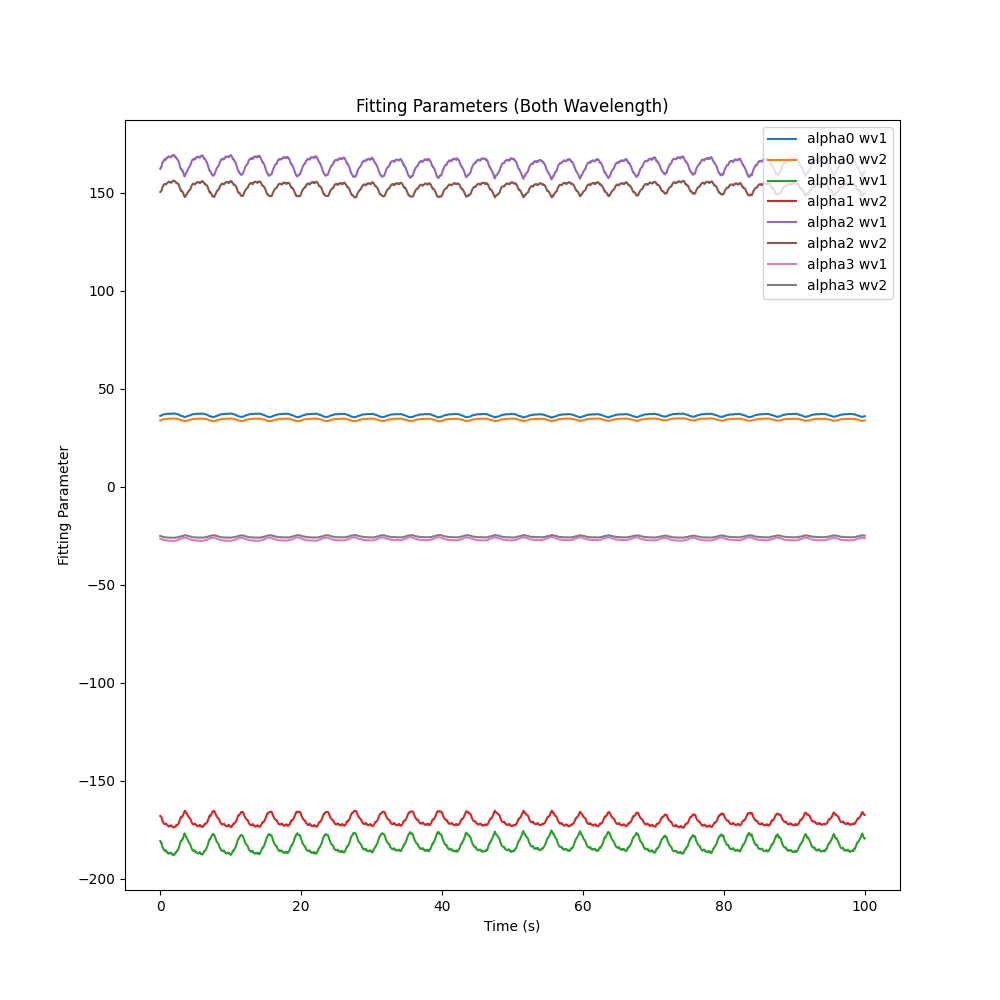

In [118]:
# Plot fitting params.
plt.figure(figsize=(10, 10))
plt.title('Fitting Parameters (Both Wavelength)')
wv1_params = fit_params[fit_params["Wave Int"] == 1.0]
wv2_params = fit_params[fit_params["Wave Int"] == 2.0]
time_axis = np.linspace(0, len(wv1_params)/80, len(wv1_params))

columns_to_plot = list(filter(lambda X: 'alpha' in X, fit_params.columns))
for column in columns_to_plot:
    plt.plot(time_axis, wv1_params[column], label=f'{column} wv1')
    plt.plot(time_axis, wv2_params[column], label=f'{column} wv2')
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Fitting Parameter")

In [119]:
print(len(time_axis))
print(len(wv1_params[column]))

8000
8000


In [120]:
# NN test
import torch
from inverse_modelling_tfo.models import train_model, create_perceptron_model
model = create_perceptron_model([4, 6, 6, 3])
model.load_state_dict(torch.load(r'../inverse_modelling_tfo/models/fetal_mu_a_model.pt'))

<All keys matched successfully>

In [121]:
alpha_means = [ -8.36710599,   9.29361004, -21.46915369,   3.94492118]
alpha_vars = [ 1258.39840231, 28541.78721394, 25152.15758128,   578.76114821]
x = (wv2_params.iloc[:, 1:].to_numpy() - np.array(alpha_means).reshape(1, -1)) / np.array(alpha_vars).reshape(1, -1)

In [122]:
with torch.no_grad():
    y = model(torch.from_numpy(x).float())

In [123]:
y = y.numpy()
# reverse scaling
y_mean = [0.17,   0.027, 20.   ]
y_var = [6.40000000e-03, 1.90666667e-04, 1.20000000e+02]
y = y * np.array(y_var).reshape(1, -1) + np.array(y_mean).reshape(1, -1)



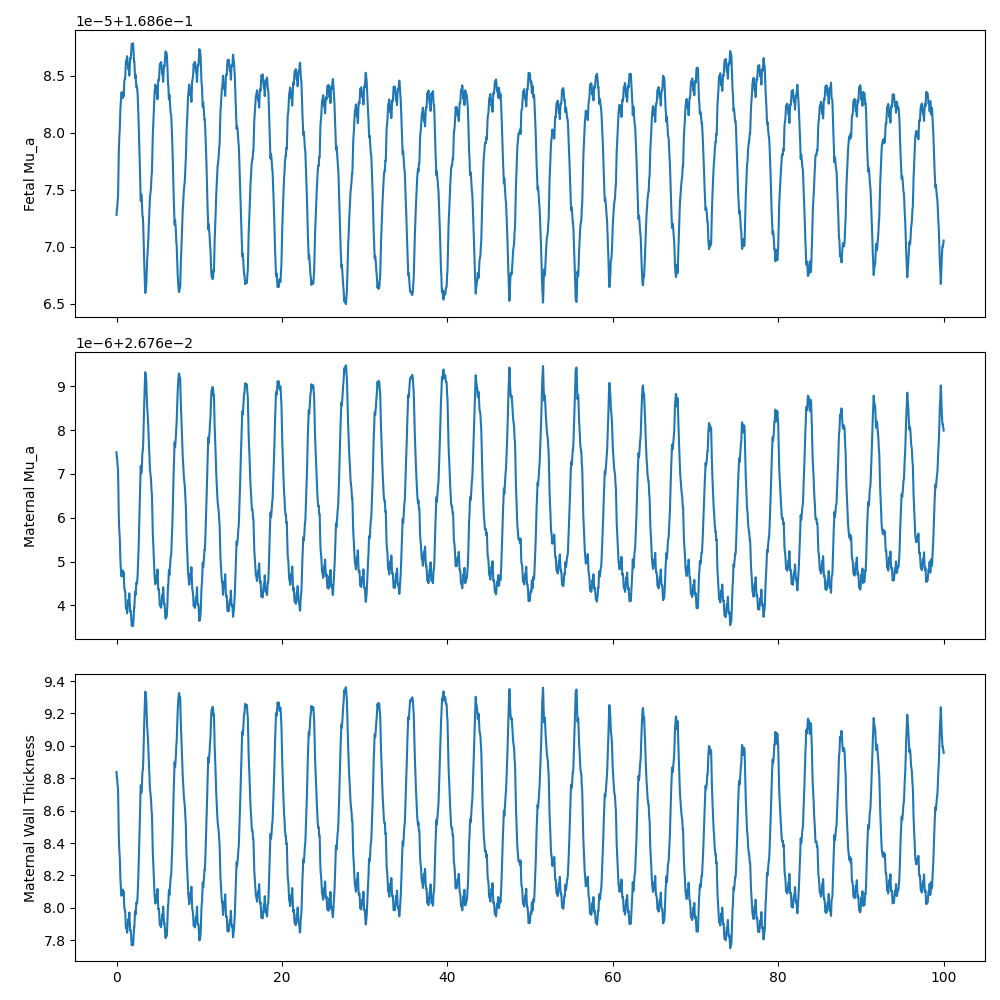

In [126]:
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
y_columns = ['Fetal Mu_a', "Maternal Mu_a", "Maternal Wall Thickness"]
for i in range(3):
    plt.sca(axes.flat[i])
    plt.plot(time_axis, y[:, i])
    plt.ylabel(y_columns[i])
fig.align_ylabels()
plt.tight_layout()
plt.show()    